# Подключение библиотек

In [39]:
import torch
import torch.nn as nn
import torch
import glob
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

import numpy as np

import os

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

print(device)

cpu


#### Разделение набора данных на выборки

In [41]:
train_path=os.path.abspath('train_list')
test_path=os.path.abspath('test_list')
val_path=os.path.abspath('val_list')


df = pd.read_csv('annotation.csv', sep = ',', header=None)

df = df.drop(df.index[0])
df.drop(0, axis=1, inplace=True)
df.rename(columns={1: 'full_path', 2: 'img_class'}, inplace=True)
df.reset_index(inplace=True)
print(df)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:    
   
    
    image_path = os.path.abspath(os.path.join(*df.full_path[i].split("\\")))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.img_class[i]}.{i}.jpg'), image)

def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
 
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(*path.split("/"), f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
 
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)


for i in range(800):
    load_train(df, train_path, i)
for i in range(1000,1800):
    load_train(df, train_path, i)
for i in range(800,900):
    load_test(df,test_path,i)
for i in range(1800,1900):
    load_test(df,test_path,i)
for i in range(900,1000):
    load_val(df,val_path,i)
for i in range(1900,1999):
    load_val(df,val_path,i)

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)

      index             full_path img_class
0         1  dataset\cat\0000.jpg       cat
1         2  dataset\cat\0001.jpg       cat
2         3  dataset\cat\0002.jpg       cat
3         4  dataset\cat\0003.jpg       cat
4         5  dataset\cat\0004.jpg       cat
...     ...                   ...       ...
1995   1996  dataset\dog\0995.jpg       dog
1996   1997  dataset\dog\0996.jpg       dog
1997   1998  dataset\dog\0997.jpg       dog
1998   1999  dataset\dog\0998.jpg       dog
1999   2000  dataset\dog\0999.jpg       dog

[2000 rows x 3 columns]


#### Проверка картинок

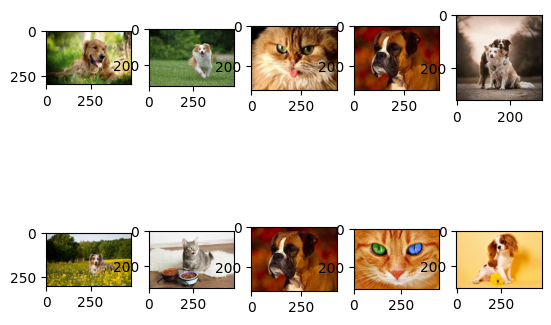

In [42]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

##### Увеличение изображений

In [43]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

#### Загрузка наборов

In [44]:
from PIL import Image
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [45]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

In [46]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[0.8353, 0.8353, 0.8353,  ..., 0.8000, 0.8000, 0.8000],
         [0.8353, 0.8353, 0.8353,  ..., 0.8000, 0.8000, 0.8000],
         [0.8353, 0.8353, 0.8353,  ..., 0.7961, 0.8000, 0.8000],
         ...,
         [0.7216, 0.7216, 0.7216,  ..., 0.9412, 0.9412, 0.9412],
         [0.7216, 0.7216, 0.7216,  ..., 0.9412, 0.9412, 0.9412],
         [0.7216, 0.7216, 0.7216,  ..., 0.9412, 0.9412, 0.9412]],

        [[0.8824, 0.8824, 0.8824,  ..., 0.7020, 0.7059, 0.7059],
         [0.8824, 0.8824, 0.8824,  ..., 0.7020, 0.7059, 0.7059],
         [0.8824, 0.8824, 0.8824,  ..., 0.6941, 0.6980, 0.6980],
         ...,
         [0.7569, 0.7569, 0.7569,  ..., 0.9647, 0.9647, 0.9647],
         [0.7529, 0.7529, 0.7529,  ..., 0.9647, 0.9647, 0.9647],
         [0.7529, 0.7529, 0.7529,  ..., 0.9647, 0.9647, 0.9647]],

        [[0.8745, 0.8745, 0.8745,  ..., 0.6745, 0.6745, 0.6745],
         [0.8745, 0.8745, 0.8745,  ..., 0.6745, 0.6745, 0.6745],
         [0.8745, 0.8745, 0.8745,  ..., 0.6627, 0.6667, 0

# Обучение

In [47]:
lr = 0.001 # learning_rate
batch_size = 10 # we will use mini-batch method
epochs = 10 # How much to train a model

In [48]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [49]:
print(len(train_data), len(train_loader))

1440 144


In [50]:
print(len(val_data), len(val_loader))

160 16
